# Sentiment Analysis

## PART2: Dataset & Sentiment Score & WordCloud

In [1]:
#Initial Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

%matplotlib inline
import plotly.express as px
from plotly import graph_objects as go
import hvplot.pandas

#NLTK
import nltk as nltk

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

nltk.download('vader_lexicon')
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aerku\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aerku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## The Dataset

In [2]:
# Import the dataset
file_path = Path("disney.csv")

df_disney = pd.read_csv(file_path, encoding="utf-8-sig")

df_disney.head()

date                                              title  \
0  2018-07-19  Comcast drops its pursuit of Fox, making way f...   
1  2018-06-13  Comcast bids $65B for Fox assets, setting the ...   
2  2018-06-07  The Comcast-Disney Battle Isn't Just Business—...   
3  2018-06-13  Comcast Offers $65 Billion in Cash to Buy Fox ...   
4  2019-03-19  Deadpool celebrates Disney-Fox merger in typic...   

                                                text  \
0  Comcast announced this morning that it’s halti...   
1  Comcast made good on its plans to make an offe...   
2  This week, there’s a swirl of stories about Co...   
3  If you were hoping to see all of your favorite...   
4  20th Century Fox\r\nIt's 20th Century Fox's fi...   

                                         description  
0  Comcast announced this morning that it’s halti...  
1  Comcast made good on its plans to make an offe...  
2  Rubert Murdoch and Brian Roberts aren't just t...  
3  If you were hoping to see all of your favorite...  
4  Ryan Reynolds further confirms he is master of...

### Calculating VADER Sentiment Score

In [3]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
stop = stopwords.words('english')

# Expand the default stopwords list if necessary
stop.extend(["Fox", "Disney","X", "Men", "’", "'s", "“","”", "would", "one", "also", "year", "company", "say", "said", "like", "deal", "``", "''", "could", "new", "New", "amp", "news", "-", "—", "two", "make", "including", "told", "get", "say", "even", "people", "get", "much", "going", "since", "want", "made", "...", "--","X-Men","content", "time", "n't", "going", "still", "last", "think", "see", "way", "well", "know", "much", "movie", "film","merger", "may"])


#Set tokenization function
def clean_text(text):
    
    
    words = word_tokenize(text)
    
    words = list(filter(lambda w:w.lower(), words))
 
    words = list(filter(lambda t:t not in punctuation, words))
    
    words = list(filter(lambda t: t.lower() not in stop, words))
    
    token = [lemmatizer.lemmatize(word) for word in words]
    
    return token

In [4]:
df_disney['token'] = df_disney['text'].apply(clean_text)
df_disney['token'].head()


0    [Comcast, announced, morning, halting, effort,...
1    [Comcast, good, plan, offer, 21st, Century, Fo...
2    [week, swirl, story, Comcast, Fox, Disney, Sky...
3    [hoping, favorite, Marvel, character, roof, ba...
4    [20th, Century, Fox, 20th, Century, Fox, first...
Name: token, dtype: object

In [5]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    # Neutral - range between -0.05 and 0.05
    result = 'neutral' 
    
    #Positive scores - higher than 0.05 & Negative scores - lower than -0.05
   
    if score >= 0.05:  # Positive
        result = 'positive'
        
    elif score <= -0.05:  # Negative
        result = 'negative'

    return result

In [6]:

# Sentiment scores dictionaries
all_sent = {
    "compound": [],
    "pos": [],
    "neu": [],
    "neg": [],
    "text_sent": [],
    #"title_sent": [],
}

# Get sentiment for the text and the title
for index, row in df_disney.iterrows():
    try:
        # Sentiment scoring with VADER
        #title_sentiment = analyzer.polarity_scores(row["title"])
        text_sentiment = analyzer.polarity_scores(row["text"])
        
        all_sent["compound"].append(text_sentiment["compound"])
        all_sent["pos"].append((text_sentiment["pos"]))
        all_sent["neu"].append((text_sentiment["neu"]))
        all_sent["neg"].append((text_sentiment["neg"]))
        #all_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))
        all_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
all_sentiment_df = pd.DataFrame(all_sent)

df_disney = df_disney.join(all_sentiment_df)

df_disney.head()

date                                              title  \
0  2018-07-19  Comcast drops its pursuit of Fox, making way f...   
1  2018-06-13  Comcast bids $65B for Fox assets, setting the ...   
2  2018-06-07  The Comcast-Disney Battle Isn't Just Business—...   
3  2018-06-13  Comcast Offers $65 Billion in Cash to Buy Fox ...   
4  2019-03-19  Deadpool celebrates Disney-Fox merger in typic...   

                                                text  \
0  Comcast announced this morning that it’s halti...   
1  Comcast made good on its plans to make an offe...   
2  This week, there’s a swirl of stories about Co...   
3  If you were hoping to see all of your favorite...   
4  20th Century Fox\r\nIt's 20th Century Fox's fi...   

                                         description  \
0  Comcast announced this morning that it’s halti...   
1  Comcast made good on its plans to make an offe...   
2  Rubert Murdoch and Brian Roberts aren't just t...   
3  If you were hoping to see all of your favorite...   
4  Ryan Reynolds further confirms he is master of...   

                                               token  compound    pos    neu  \
0  [Comcast, announced, morning, halting, effort,...    0.9930  0.212  0.788   
1  [Comcast, good, plan, offer, 21st, Century, Fo...    0.9758  0.114  0.858   
2  [week, swirl, story, Comcast, Fox, Disney, Sky...    0.5310  0.079  0.844   
3  [hoping, favorite, Marvel, character, roof, ba...    0.8981  0.103  0.822   
4  [20th, Century, Fox, 20th, Century, Fox, first...    0.8834  0.069  0.919   

     neg text_sent  
0  0.000  positive  
1  0.028  positive  
2  0.077  positive  
3  0.075  positive  
4  0.013  positive

In [7]:
df_disney.describe()

compound          pos          neu         neg
count  2893.000000  2893.000000  2893.000000  2893.00000
mean      0.751804     0.107974     0.847400     0.04463
std       0.545417     0.040060     0.050479     0.03055
min      -1.000000     0.000000     0.617000     0.00000
25%       0.901400     0.080000     0.815000     0.02200
50%       0.983000     0.105000     0.849000     0.03900
75%       0.995700     0.133000     0.881000     0.06200
max       1.000000     0.311000     1.000000     0.21500

In [8]:
# Groupby Sentiment of the news
temp = df_disney.groupby('text_sent').count()['text'].reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap='Purples')


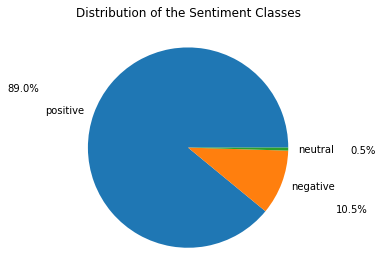

In [9]:
plt.pie(temp.text, labels = temp.text_sent, autopct= '%1.1f%%', pctdistance=1.75)
plt.title('Distribution of the Sentiment Classes')
plt.tight_layout()
plt.show()

In [10]:
# Sentiment Distribution graph

fig = go.Figure(go.Funnelarea(
    text = temp.text_sent,
    values = temp.text,
    title = 'Sentiment Distribution'
))

fig.show()

In [11]:
#Negative Sentiments - Creating DataFrame
df_neg = df_disney.loc[df_disney['text_sent'] == 'negative']
df_neg.head()

date                                              title  \
20  2018-06-12  DOJ Blows Its Chance to Stop Disastrous Merger...   
22  2018-11-03  Here's why cord-cutters should be worried abou...   
39  2018-06-12         What you need to know in advertising today   
57  2019-04-04  Disney Has Hopes for More Alien and Planet of ...   
60  2019-03-04  Fox News was always partisan, but now it is ru...   

                                                 text  \
20  On Tuesday, a federal judge ruled that AT&amp;...   
22  On Thursday, HBO and Cinemax went dark for som...   
39  Federal judge Richard Leon will issue an opini...   
57  Get a better look at Detective Pikachus cast o...   
60  Building on her excellent work in 2017's Dark ...   

                                          description  \
20  On Tuesday, a federal judge ruled that AT&amp;...   
22  On Thursday, HBO and Cinemax went dark for som...   
39  Federal judge Richard Leon will issue an opini...   
57  Get a better look at Detective Pikachu ’s cast...   
60  Building on her excellent work in 2017's Dark ...   

                                                token  compound    pos    neu  \
20  [Tuesday, federal, judge, ruled, clear, merge,...   -0.9987  0.067  0.801   
22  [Thursday, HBO, Cinemax, went, dark, Dish, cus...   -0.8945  0.078  0.826   
39  [Federal, judge, Richard, Leon, issue, opinion...   -0.2023  0.044  0.903   
57  [better, look, Detective, Pikachus, cast, pock...   -0.9743  0.043  0.882   
60  [Building, excellent, work, 2017, Dark, Money,...   -0.9385  0.055  0.876   

      neg text_sent  
20  0.132  negative  
22  0.096  negative  
39  0.053  negative  
57  0.075  negative  
60  0.068  negative

In [12]:
#Positive Sentiments - Creating DataFrame
df_pos = df_disney.loc[df_disney['text_sent'] == 'positive']
df_pos.head()

date                                              title  \
0  2018-07-19  Comcast drops its pursuit of Fox, making way f...   
1  2018-06-13  Comcast bids $65B for Fox assets, setting the ...   
2  2018-06-07  The Comcast-Disney Battle Isn't Just Business—...   
3  2018-06-13  Comcast Offers $65 Billion in Cash to Buy Fox ...   
4  2019-03-19  Deadpool celebrates Disney-Fox merger in typic...   

                                                text  \
0  Comcast announced this morning that it’s halti...   
1  Comcast made good on its plans to make an offe...   
2  This week, there’s a swirl of stories about Co...   
3  If you were hoping to see all of your favorite...   
4  20th Century Fox\r\nIt's 20th Century Fox's fi...   

                                         description  \
0  Comcast announced this morning that it’s halti...   
1  Comcast made good on its plans to make an offe...   
2  Rubert Murdoch and Brian Roberts aren't just t...   
3  If you were hoping to see all of your favorite...   
4  Ryan Reynolds further confirms he is master of...   

                                               token  compound    pos    neu  \
0  [Comcast, announced, morning, halting, effort,...    0.9930  0.212  0.788   
1  [Comcast, good, plan, offer, 21st, Century, Fo...    0.9758  0.114  0.858   
2  [week, swirl, story, Comcast, Fox, Disney, Sky...    0.5310  0.079  0.844   
3  [hoping, favorite, Marvel, character, roof, ba...    0.8981  0.103  0.822   
4  [20th, Century, Fox, 20th, Century, Fox, first...    0.8834  0.069  0.919   

     neg text_sent  
0  0.000  positive  
1  0.028  positive  
2  0.077  positive  
3  0.075  positive  
4  0.013  positive

In [13]:
#Token Count defining function
from collections import Counter
def token_count(token, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(token).most_common(N)

### Negative Words

In [14]:
# Top 50 for Negative Words
big_string = ' '.join(df_neg['text'])
input_neg = clean_text(big_string)
top50_n = token_count(input_neg, 50)
print(top50_n)


[('Fox', 1439), ('Disney', 969), ('Trump', 808), ('published', 403), ('billion', 386), ('Warner', 330), ('Originally', 329), ('X-Men', 316), ('first', 313), ('CBS', 307), ('series', 307), ('woman', 294), ('million', 290), ('Marvel', 287), ('say', 279), ('Dark', 278), ('Phoenix', 273), ('medium', 265), ('show', 263), ('2018', 259), ('story', 254), ('TV', 253), ('Century', 252), ('take', 251), ('Images', 251), ('year', 250), ('2019', 249), ('Christmas', 248), ('Television', 248), ('Netflix', 243), ('Getty', 243), ('company', 242), ('report', 234), ('back', 228), ('Fallout', 222), ('work', 215), ('Star', 215), ('former', 211), ('sexual', 210), ('come', 206), ('release', 204), ('network', 201), ('2', 200), ('director', 197), ('US', 195), ('set', 193), ('Times', 190), ('studio', 189), ('film', 189), ('government', 187)]


In [15]:
# Most common words - Negative
temp_n = pd.DataFrame(top50_n)
temp_n.columns = ['Common_words', 'count']
temp_n.style.background_gradient(cmap='Reds')


In [16]:
# Most Common Words in  Negative Sentiment

fig = px.treemap(temp_n, path = ['Common_words'], values='count', title = 'Tree of Most Common Words - Negative')
fig.show()

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

Text(0.5, 1.0, 'Disney-Fox Merger - Common Words for Negative News Articles - Word Cloud')

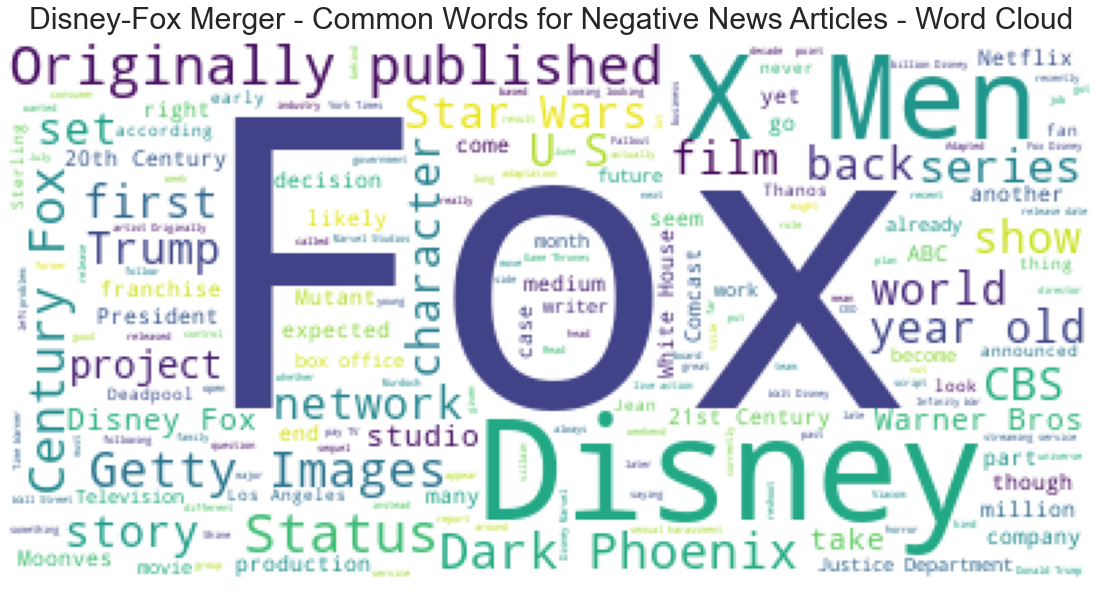

In [18]:
wc_n = WordCloud(background_color= 'white', 
               mask = None,
               max_font_size = 150
              ).generate(' '.join(input_neg))
plt.imshow(wc_n)
plt.axis('off')
#plt.tight_layout()
plt.title('Disney-Fox Merger - Common Words for Negative News Articles - Word Cloud', fontdict={'size' : 30, 'verticalalignment' : 'bottom'})

### Positive Words

In [19]:
# Top 50 for Positive Words
big_stringp = ' '.join(df_pos['text'])
input_pos = clean_text(big_stringp)
top50_p = token_count(input_pos, 50)
print(top50_p)

[('Fox', 12827), ('Disney', 12579), ('Marvel', 5713), ('billion', 4054), ('X-Men', 3764), ('Comcast', 3759), ('Netflix', 3071), ('Century', 2970), ('TV', 2902), ('character', 2886), ('show', 2705), ('medium', 2634), ('business', 2493), ('Warner', 2488), ('first', 2473), ('service', 2452), ('company', 2405), ('year', 2379), ('studio', 2354), ('network', 2299), ('million', 2249), ('streaming', 2197), ('movie', 2189), ('share', 2059), ('thing', 2022), ('right', 2011), ('asset', 1984), ('Avengers', 1961), ('back', 1909), ('franchise', 1881), ('Deadpool', 1870), ('come', 1842), ('go', 1819), ('acquisition', 1803), ('big', 1801), ('take', 1790), ('stock', 1753), ('series', 1753), ('MCU', 1739), ('offer', 1691), ('already', 1675), ('Studios', 1672), ('lot', 1667), ('story', 1650), ('next', 1643), ('many', 1575), ('look', 1563), ('film', 1563), ('21st', 1548), ('price', 1523)]


In [20]:
# Most common words - Positive
temp_p = pd.DataFrame(top50_p)
temp_p.columns = ['Common_words', 'count']
temp_p.style.background_gradient(cmap='Greens')


In [21]:
# Most Common Words - Positive Sentiment

fig1 = px.treemap(temp_p, path = ['Common_words'], values='count', title = 'Tree of Most Common Words')
fig1.show()

Text(0.5, 1.0, 'Disney-Fox Merger - Common Words for Positive News Articles - Word Cloud')

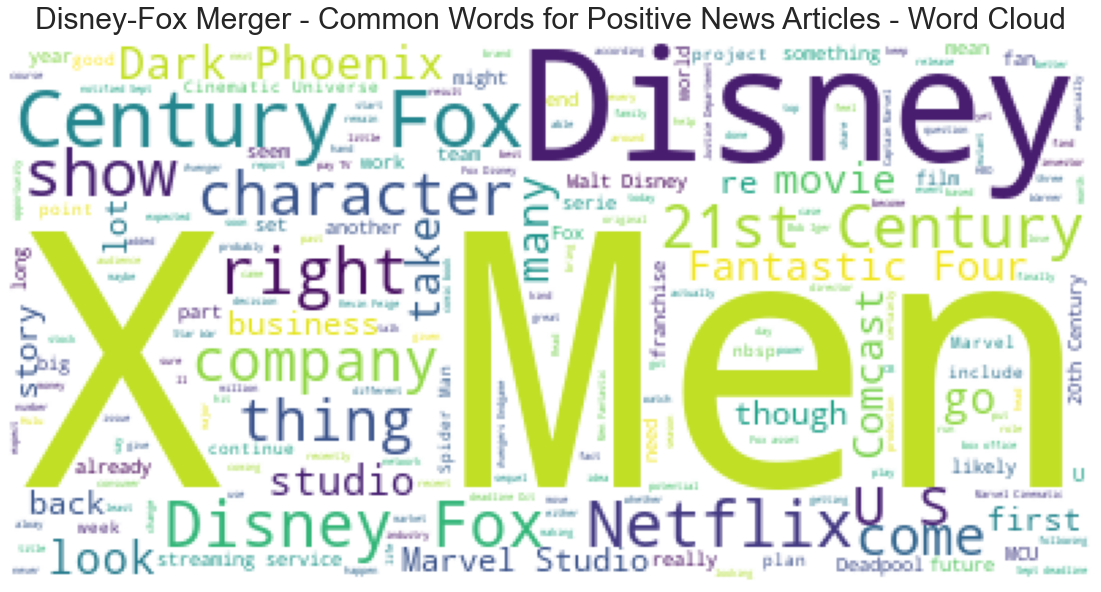

In [22]:
wc_p = WordCloud(background_color= 'white', 
               mask = None,
               max_font_size = 150
              ).generate(' '.join(input_pos))
plt.imshow(wc_p)
plt.axis('off')
#plt.tight_layout()
plt.title('Disney-Fox Merger - Common Words for Positive News Articles - Word Cloud', fontdict={'size' : 30, 'verticalalignment' : 'bottom'})

In [23]:
## Save the file CSV format 

In [24]:
file_path = Path("df_disney.csv")
df_disney.to_csv(file_path, index=False, encoding='utf-8-sig')